# Perceptron

- Threshold logic unit (TLU): Computes a weighted sum of the inputs then applies a **step function**

- Step functions: 

     1. $\text{heaviside}(z) \begin{cases} 0 && \text{ if } z < 0 \\ 1 && \text{ if } z \geq 0\end{cases}$
     2. $\text{sign}(z) \begin{cases} -1 && \text{ if } z < 0 \\ 0 && \text{ if } z = 0 \\ 1 && \text{ if } z > 0\end{cases}$


- Fully connected layer / dense layer: when all neurons in a layer are connected to every neuron in the previous layer. The outputs of a fully connected layers are defined as: $h_{w,b}(X) = \phi(XW+b)$, where X=input features, W=weights, b=bias, $\phi$=activation function


- Bias neuron: a neuron that always outputs a fixed value. Bias neurons help the model to: 
     - handle non-zero centered data
     - Be more flexible, such as shifting decision boundaries
     - Control activation function offsets and better generalization


- Training of perceptron: For every output neuron that produced an error, the connection weights between the neurons that produced the correct result are reinforced: 

     $w_{i,j}^\text{next step} = w_{i,j} + \eta(y_j - \hat{y}_j) x_i$

     Where
     $w_{i,j}$ = connection weights between input i and output j,
     $x_i$ = ith input value of the current training instance,
     $\hat{y}_j$ = output for the jth output neuron for the current training instance,
     $y_j$  = target output of the jth output neuron for the current training instance,
     $\eta$ = learning rate

- Assumption: Perceptron will converge to a solution if the training instances are linearly separable 

- Weakness: cannot solve some trivial problems (e.g., XOR problems)
     

# Multilayer perceptron & backpropagation

```
1 output layer          <- TLU                ↑              backward
     ↑                                        |                 |
(1 to n) hidden layers  <- TLU                |[backpropagation]|
     ↑                                        |                 |
1 input layer           <- Passthrough     forward              ↓   

```

- Backpropagation: calculate the gradient automatically in two pass-throughs of the network (forward and backward) w.r.t. every single model parameter--> [reverse-mode] autodiff
     - that is, backpropagation helps find out how the weight and bias ter should be tweaked to reduce error

- Training algorithm and steps: 
     1. The algorithm handles a minibatch at a time, and goes through the full training set multiple times. Each pass is an **epoch** 
     2. Forward pass: making predictions and storing all intermediate results
     3. Finding error: using **loss functions**
     4. Compute how much each output connection contributed to the error using **chain rule** 
     5. Compute how much each connection in the network contributed to the error using chain rule, again
     6. Perform **gradient descent step** to tweak all connection weights

- During training, all weights need to be randomly initiated, since identical weights may cause the backpropagation algorithm to yield similar results for different inputs ("it won't be too smart").

- Some popular activation functions for gradient descent: 
     - GD cannot work on flat surfaces (functions) and require functions which has nonzero derivative everywhere so that GD can make progress. 
     - Activation functions are needed because chaining several linear transformations will also yield a similar linear transformation. This will cause a deep network to behave like a single layer network.

|   Function  |   Formula    |   Notes | 
|:-------|:-------|:------|
| Logistic (sigmoid) | $\sigma(z) = \frac{1}{1 + exp(-z)}$ | |
| Hyperbolic tangent | $\text{tanh}(z) = 2\sigma(2z) - 1$ | S-shaped, differentiable. Output ranges (-1, 1) and centered around 0 at beginning of training, giving it faster convergence speed  |
| Rectified Linear Unit (ReLU) | $\text{ReLU}(z) = \text{max}(0,z)$ |  Continuous, but not differentiable at z = 0, and derivative is 0 for z < 0. Helps computational speed and vanishing gradient during GD (specifically vanishing gradient) | 
| Softplus | $\text{softplus}(z) = \text{log}(1 + \text{exp}(z))$ | |

In [24]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import MeanSquaredError #? 
from tensorflow.keras.optimizers import SGD

# predifine arguments for keras.utils.plot_model()
PLOT_MODEL_ARGS = {"show_shapes" : True,
                   "show_layer_activations": True,
                   "show_layer_names" : False}

%matplotlib inline

(np.__version__, matplotlib._version.version, tf.__version__, keras.__version__)

('1.25.0', '3.6.0', '2.10.0', '2.10.0')

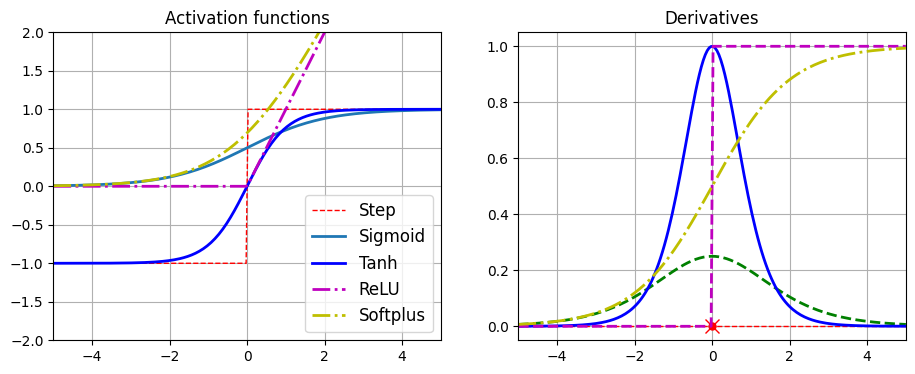

In [37]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

sigmoid = lambda x: 1/(1+np.exp(-x))
relu = lambda x: np.maximum(0, x)
softplus = lambda x: np.log(1 + np.exp(x))

plt.subplot(121)
plt.plot(z, np.sign(z), 'r--', linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth = 2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot(z, softplus(z), "y-.", linewidth=2, label="Softplus")
plt.grid(True)
plt.legend(loc = "lower right", fontsize = 12)
plt.title("Activation functions", fontsize = 12)
plt.axis([-5, 5, -2, 2])
plt.plot()


# Derivative function
dev = lambda func, x, eps=1e-5: (func(x + eps) - func(x - eps)) / (2 * eps)

plt.subplot(122)
plt.plot(z, dev(np.sign, z), "r--", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, dev(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, dev(np.tanh, z), "b-", linewidth=2, label="tanh")
plt.plot(z, dev(relu, z), "m--", linewidth=2, label="ReLU")
plt.plot(z, dev(softplus,z), "y-.", linewidth=2, label="Softplus")
plt.grid(True)
plt.title("Derivatives", fontsize=12)
plt.axis([-5, 5, -0.05, 1.05])

plt.show()

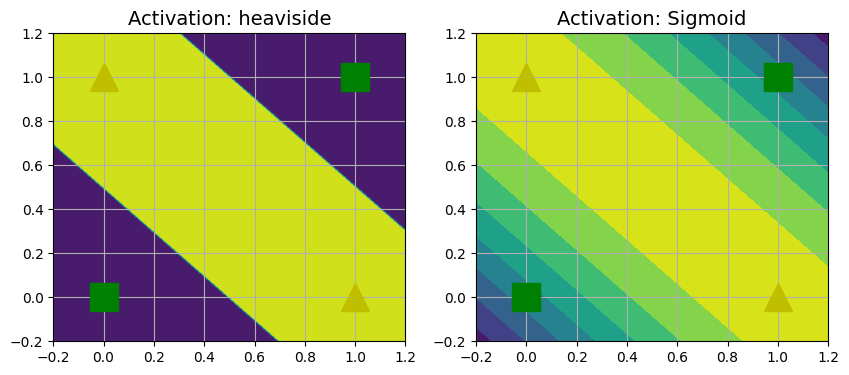

In [5]:
x1, x2 = np.meshgrid(np.linspace(-0.2, 1.2, 100),
                     np.linspace(-0.2, 1.2, 100))

heaviside = lambda x: (x>=0).astype(x.dtype)

# the MLP xor problem
mlp_xor = lambda x1, x2, act=heaviside: act(-act(x1 + x2 - 1.5) + act(x1 + x2 - 0.5) - 0.5)

z1 = mlp_xor(x1, x2, act=heaviside)
z2 = mlp_xor(x1, x2, act=sigmoid)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0,1], [0,1], "gs", markersize=20)
plt.plot([0,1], [1,0], "y^", markersize=20)
plt.title("Activation: heaviside", fontsize = 14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0,1], [0,1], "gs", markersize=20)
plt.plot([0,1], [1,0], "y^", markersize=20)
plt.title("Activation: Sigmoid", fontsize = 14)
plt.grid(True)

# Regression & classification MLPs

| Hyperparameter | Regression MLP  | Binary classification MLP  |  Multilabel binary <br>classification MLP |  Multiclass MLP   | 
|:------|:------|:------|:------|:------|
| # Input neurons | One per input feature | One per input feature | One per input feature | One per input feature |
| # Hidden layers | Depends on problem<br>(1-5 typically) | Depends on problem  |  Depends on problem| Depends on problem|
| # Neurons per <br> hidden layer | Depends on problem<br>(10-100 typically) | Depends on problem | Depends on problem| Depends on problem|
| # Output neurons | 1 per prediction dimension  | 1 | 1 per label  |  1 per class |
| Hidden activation | ReLU or SELU  || | |
| Output activation | - None<br>- Positive outputs: ReLU/Softplus<br> - Bounded inputs: Logistic/tanh| Logistic | Logistic | Softmax |
| Loss function  | - MSE<br>- If outlier: MAE/Huber | Cross entropy | Cross entropy | Cross entropy |

# MLP w/Tensorflow

In [38]:
# load data and inspect shape/dtype

#              ┌───────────────────────────┐
#              │       Fashion MNIST       │
#          ┌───┤ (60000 28*28  grey-scale) ├──┐
#          │   └───────────────────────────┘  │
#       ┌───────────────────┐  ┌─────────────────┐
#       │     Train set     │  │     Test set    │
#       │    50000 images   │  │   10000 images  │
#       └──┬─────────────┬──┘  └─────────────────┘
# ┌────────┴────┐  ┌─────┴──────────┐
# │  Train set  │  │ Validation set │
# │ 45000 images│  │   5000 images  │
# └─────────────┘  └────────────────┘

fm = keras.datasets.fashion_mnist
(X_train, y_train), (x_test, y_test) = fm.load_data()
(X_train.shape, y_train.shape), (X_train.dtype, y_train.dtype)

(((60000, 28, 28), (60000,)), (dtype('uint8'), dtype('uint8')))

In [39]:
# Create validation set
# Scale --> divide by 255.0 (since applying GD to image data)
# !! It is generally a good idea to scale the image for: 
# !! 1. Numeric stability and speed of convergence
# !! 2. Consistency of image feature importance
POS = 5000  
x_val, x_train = X_train[:POS] / 255.0, X_train[POS:] / 255.0
y_val, y_train = y_train[:POS], y_train[POS:]
x_test = x_test / 255.0
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 300)               235500    
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                                 
 dense_14 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


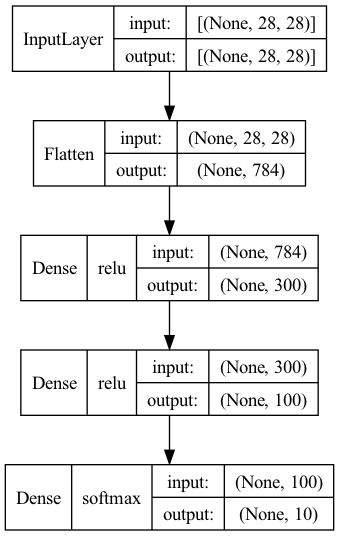

In [41]:
# build model 
model = keras.models.Sequential()

# First flatten the input to 1D 
# alternatively, this can be written as: 
# model.add(keras.layers.InputLayer(input_shape=[28,28]))
model.add(keras.layers.Flatten(input_shape=[28,28]))

# each of the layer manage its weight matrix and bias term
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# Inspect model
model.summary()
keras.utils.plot_model(model=model,**PLOT_MODEL_ARGS)

In [42]:
# Inspect model layer and accessing specific layers 
# To get a full list of model layers, use: model.layers
print(f"list of layers:\n{*model.layers,}\n")

# Since model.layers returns a list, we can use list indexing to get the specific layer of interest
first_layer = model.layers[1]
print(f"First layer of the model:\n{first_layer}\n")
print(f"Name of the first layer:\n{model.layers[1].name}\n")

# Model layer weights and biases can be obtained using layer.get_weights() 
w, b = first_layer.get_weights()
print(f"weight of first layer (shape = {w.shape}):\n{w}\n")
print(f"bias of first layer (shape = {b.shape}):\n{b}")

list of layers:
(<keras.layers.reshaping.flatten.Flatten object at 0x281b6fbe0>, <keras.layers.core.dense.Dense object at 0x284bebc70>, <keras.layers.core.dense.Dense object at 0x307c79db0>, <keras.layers.core.dense.Dense object at 0x307c7ab00>)

First layer of the model:

Name of the first layer:
dense_12

weight of first layer (shape = (784, 300)):
[[ 0.062354    0.07196379  0.00612018 ...  0.07317443  0.04604109
   0.01880745]
 [-0.02686652  0.01228125  0.00241171 ...  0.02343449 -0.01344365
  -0.06334952]
 [-0.02413858 -0.03285469  0.03997631 ... -0.07255914 -0.04832315
  -0.05049639]
 ...
 [ 0.06917541  0.06548977  0.01314817 ... -0.07058516  0.0641316
  -0.05628508]
 [-0.0671128  -0.04619469  0.06446798 ... -0.0528897   0.05924633
  -0.02174725]
 [ 0.02821846 -0.04926792 -0.06179056 ... -0.02503686  0.02012313
   0.03772672]]

bias of first layer (shape = (300,)):
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [43]:
# compile model 
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(), # lr can be specified in arguments `lr = n`
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [ ]:
# train model, output omitted
history = model.fit(x_train, y_train,
                    epochs = 30,
                    validation_data = (x_val, y_val))

In [48]:
# inspect history object
history.params, history.history.keys()

({'verbose': 1, 'epochs': 30, 'steps': 1719},
 dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']))

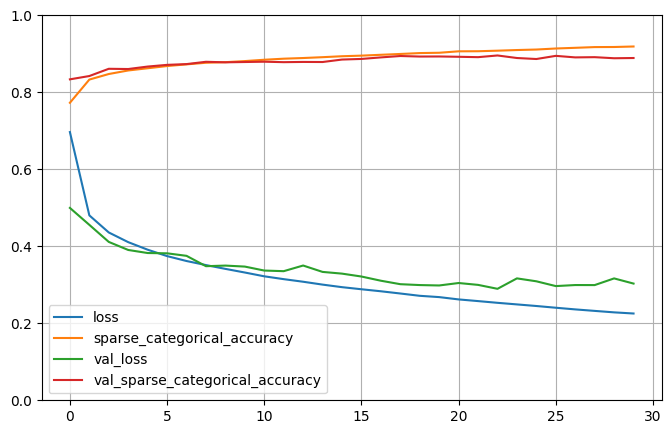

In [49]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [55]:
# evaluate the model
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3375 - sparse_categorical_accuracy: 0.8776


[0.33753272891044617, 0.8776000142097473]

In [61]:
# predict using the model
x_new = x_test[:3]

# return probability for all classes
y_prob = model.predict(x_new)
print(y_prob.round(2))

# Return the highest estimated probability
print(np.argmax(y_prob, axis = -1))

1/1 [==============================] - 0s 12ms/step
[[0.   0.   0.   0.   0.   0.01 0.   0.02 0.   0.97]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]
[9 2 1]


In [62]:
# clean up: 
del model, x_test, x_train, X_train, y_train, y_test, y_val, x_val, y_prob, history

# Regression MLP

In [35]:
data = fetch_california_housing() 

# Train test split
X_train, x_test, y_train, y_test = train_test_split(
    data.data, data.target
)

# train validation split
X_train, x_val, y_train, y_val = train_test_split(
    X_train, y_train
)

# feature scaling - fit transform on train set and transform on val and test set
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(1)
])

# skipped training this model
model.compile(loss = MeanSquaredError(), 
              optimizer = SGD())

history = model.fit(X_train, y_train, epochs = 5,
                    validation_data = (x_val, y_val))

mse_test = model.evaluate(x_test, y_test)
X_new = x_test[:3]
y_pred = model.predict(X_new) 

Epoch 1/5
363/363 [==============================] - 2s 5ms/step - loss: 0.7293 - val_loss: 0.5390
Epoch 2/5
363/363 [==============================] - 2s 5ms/step - loss: 0.4882 - val_loss: 0.5023
Epoch 3/5
363/363 [==============================] - 2s 4ms/step - loss: 0.4794 - val_loss: 3.3029
Epoch 4/5
363/363 [==============================] - 2s 4ms/step - loss: 0.5051 - val_loss: 0.4011
Epoch 5/5
1/1 [==============================] - 0s 76ms/step


# Complex models

## Wide and deep models

```
Model 1: only 1 input                       Model 2: Combining 2 inputs
        ┌────────────────┐                    ┌─────────┐    ┌─────────┐
        │  Input layer   ├───────┐            │ Input 1 │    │ Input 2 │
        └───────┬────────┘       │            └───┬─────┘    └────┬────┘
                │                │                │               │
        ┌───────▼────────┐       │                │       ┌───────▼────────┐
        │ Hidden layer 1 │       │                │       │ Hidden layer 1 │
        └───────┬────────┘       │                │       └───────┬────────┘
                │                │                │               │
        ┌───────▼────────┐       │                │       ┌───────▼────────┐
  deep  │ Hidden layer 2 │     wide               │       │ Hidden layer 2 │
        └───────┬────────┘       │                │       └───────┬────────┘
                │                │                │               │
        ┌───────▼────────┐       │           ┌────▼───────────────▼────────┐
        │     Concat     ◄───────┘           │        Concatenation        │
        └───────┬────────┘                   └────────────┬────────────────┘
                │                                         │
        ┌───────▼────────┐                        ┌───────▼────────┐
        │  Output layer  │                        │  Output layer  │
        └────────────────┘                        └────────────────┘
```

- Deep: learndeep patterns
- Wide: learn simple rules 


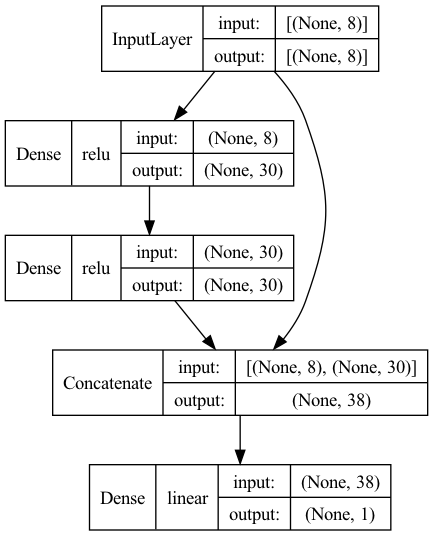

In [31]:
# model 1
input = keras.layers.Input(shape = X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation = "relu")(input)
hidden2 = keras.layers.Dense(30, activation = "relu")(hidden1)
concat = keras.layers.Concatenate()([input, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.Model(inputs = [input], outputs = [output])

keras.utils.plot_model(model=model, **PLOT_MODEL_ARGS)

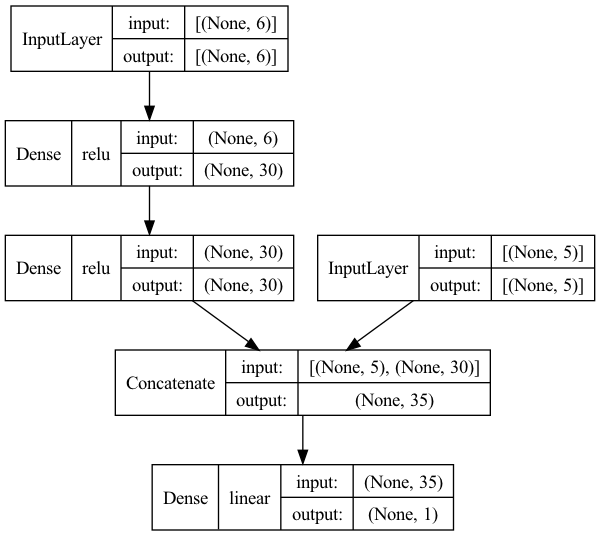

In [36]:
# model 2
input1 = keras.layers.Input(shape = [5], name = "wide_input")
input2 = keras.layers.Input(shape = [6], name = "deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input2)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input1, hidden2])
output = keras.layers.Dense(1, name = "output")(concat)
model = keras.Model(inputs = [input1, input2], outputs = [output])

keras.utils.plot_model(model=model, **PLOT_MODEL_ARGS)

In [37]:
model.compile(loss = keras.losses.MeanSquaredError(),
              optimizer = keras.optimizers.SGD(lr = 1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
x_valid_A, x_valid_B = x_val[:, :5], x_val[:, 2:]
x_test_A, x_test_B = x_test[:, :5], x_test[:, 2:]
x_new_a, x_new_b = x_test_A[:3], x_test_B[:3]

history = model.fit((X_train_A, X_train_B), # or alternatively {"wide_input": "X_train_A", "deep_input":X_train_B}
                    y_train, epochs=5,
                    validation_data = ((x_valid_A, x_valid_B), y_val))

mse_test = model.evaluate((x_test_A, x_test_B), y_test)
y_pred = model.predict((x_new_a, x_new_b))

Epoch 1/5


/Users/randy/.conda/envs/numpy_m1_build/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


363/363 [==============================] - 2s 6ms/step - loss: 2.2743 - val_loss: 1.0506
Epoch 2/5
363/363 [==============================] - 2s 6ms/step - loss: 0.8527 - val_loss: 0.7110
Epoch 3/5
363/363 [==============================] - 2s 5ms/step - loss: 0.6997 - val_loss: 0.6226
Epoch 4/5
363/363 [==============================] - 2s 5ms/step - loss: 0.6376 - val_loss: 0.5754
Epoch 5/5
1/1 [==============================] - 0s 40ms/step


## Multiple output models 

- Multi-output models are used when: 
     1. Tasks that require multiple outputs, such as object detection
     2. Tasks with multiple sub-tasks - the network could learn information that is useful across different sub-tasks
     3. Regularization

```
 Model 3: Producing 2 outputs
   ┌─────────┐    ┌─────────┐
   │ Input 1 │    │ Input 2 │
   └────────┬┘    └────┬────┘
            │          │
            │  ┌───────▼────────┐
            │  │ Hidden layer 1 │
            │  └───────┬────────┘
            │          │
            │  ┌───────▼────────┐
            │  │ Hidden layer 2 │
            │  └─┬────────────┬─┘
            │    │            │
         ┌──▼────▼──────┐     │
         │ Concatenation│     │
         └─────┬────────┘     │
               │              │
       ┌───────▼────────┐   ┌─▼─────────┐
       │  Output layer  │   │Aux. output│  <--- Need to define loss function seperately 
       └────────────────┘   └───────────┘
```

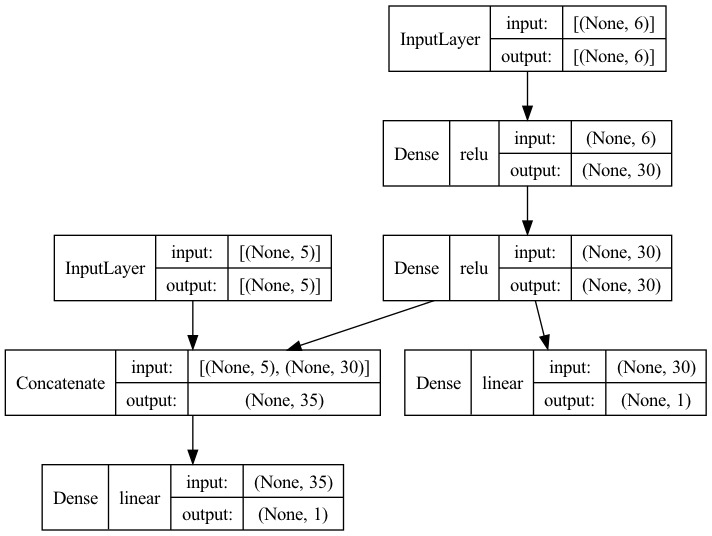

In [38]:
# model 3
input1 = keras.layers.Input(shape = [5], name = "wide_input")
input2 = keras.layers.Input(shape = [6], name = "deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input2)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input1, hidden2])
output1 = keras.layers.Dense(1, name = "output")(concat)
output2 = keras.layers.Dense(1, name = "aux_output")(hidden2)

# specify outputs
model = keras.Model(inputs = [input1, input2], outputs = [output1, output2])

keras.utils.plot_model(model = model, **PLOT_MODEL_ARGS)

In [39]:
# define loss function for individual outputs
model.compile(loss = [MeanSquaredError(), MeanSquaredError()],
              loss_weights = [0.9, 0.1],
              optimizer= SGD())

history = model.fit([X_train_A, X_train_B], 
                    [y_train, y_train],
                    epochs=5,
                    validation_data=([x_valid_A, x_valid_B], [y_val, y_val]))

Epoch 1/5
363/363 [==============================] - 3s 9ms/step - loss: 0.9262 - output_loss: 0.8196 - aux_output_loss: 1.8860 - val_loss: 0.5777 - val_output_loss: 0.5150 - val_aux_output_loss: 1.1419
Epoch 2/5
363/363 [==============================] - 3s 8ms/step - loss: 0.5535 - output_loss: 0.4986 - aux_output_loss: 1.0480 - val_loss: 0.5078 - val_output_loss: 0.4633 - val_aux_output_loss: 0.9082
Epoch 3/5
363/363 [==============================] - 3s 8ms/step - loss: 0.5039 - output_loss: 0.4634 - aux_output_loss: 0.8691 - val_loss: 0.4839 - val_output_loss: 0.4494 - val_aux_output_loss: 0.7948
Epoch 4/5
363/363 [==============================] - 3s 8ms/step - loss: 0.4776 - output_loss: 0.4472 - aux_output_loss: 0.7511 - val_loss: 0.4354 - val_output_loss: 0.4079 - val_aux_output_loss: 0.6832
Epoch 5/5
363/363 [==============================] - 3s 8ms/step - loss: 0.4558 - output_loss: 0.4313 - aux_output_loss: 0.6769 - val_loss: 0.4483 - val_output_loss: 0.4275 - val_aux_outpu